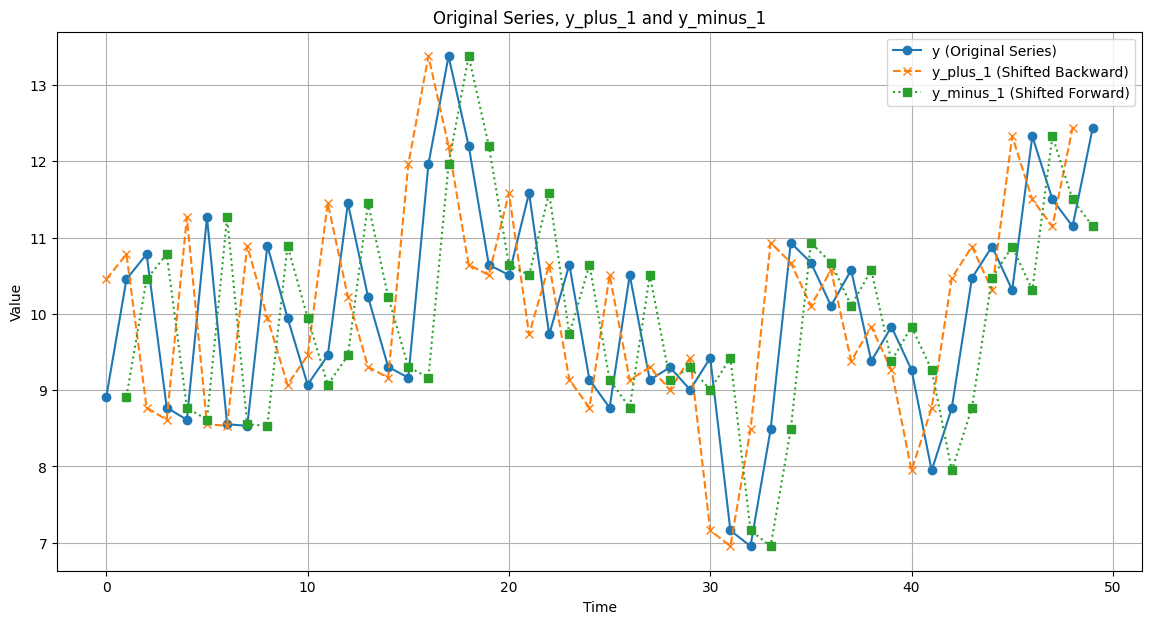

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm

# Generate synthetic AR(p) series
np.random.seed(123)
ar_params = np.array([1, -0.5, 0.25])
ma_params = np.array([1])
ar_process = ArmaProcess(ar_params, ma_params)
synthetic_ar_data = ar_process.generate_sample(nsample=50)
synthetic_ar_series = pd.Series(synthetic_ar_data)
synthetic_ar_series = synthetic_ar_series + 10

# Create y, y_plus_1, and y_minus_1
y = synthetic_ar_series
y_plus_1 = y.shift(-1)
y_minus_1 = y.shift(1)

# Plot the series
plt.figure(figsize=(14, 7))

plt.plot(y, label='y (Original Series)', marker='o')
plt.plot(y_plus_1, label='y_plus_1 (Shifted Backward)', linestyle='--', marker='x')
plt.plot(y_minus_1, label='y_minus_1 (Shifted Forward)', linestyle=':', marker='s')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Series, y_plus_1 and y_minus_1')
plt.legend()
plt.grid(True)
plt.show()


In [2]:
# Prepare data for linear regression (drop NaN values due to shifting)
df = pd.DataFrame({'y_plus_1': y_plus_1,
                   'y': y,
                   'y_minus_1': y_minus_1
                   }).dropna()

display(df.head())

# Perform linear regression
X = df[['y_minus_1', 'y_plus_1']]
X = sm.add_constant(X)
model = sm.OLS(df['y'], X)
results = model.fit()

# # Print the regression results
# print(results.summary())

,y_plus_1,y,y_minus_1
1,10.781651,10.454530,8.914369
2,8.770898,10.781651,10.454530
3,8.611436,8.770898,10.781651
4,11.264430,8.611436,8.770898
5,8.552677,11.264430,8.611436


In [3]:
print(results.params)

const        1.775194
y_minus_1    0.405147
y_plus_1     0.417163
dtype: float64


In [4]:
print(results.params)
phi_0 = results.params['const']
phi_1 = results.params['y_minus_1']
alfa_1 = results.params['y_plus_1']
print(f'\nphi_0: {phi_0:.7}\nphi_1: {phi_1:.7}\nalfa_1: {alfa_1:.7}')

const        1.775194
y_minus_1    0.405147
y_plus_1     0.417163
dtype: float64

phi_0: 1.775194
phi_1: 0.4051471
alfa_1: 0.417163


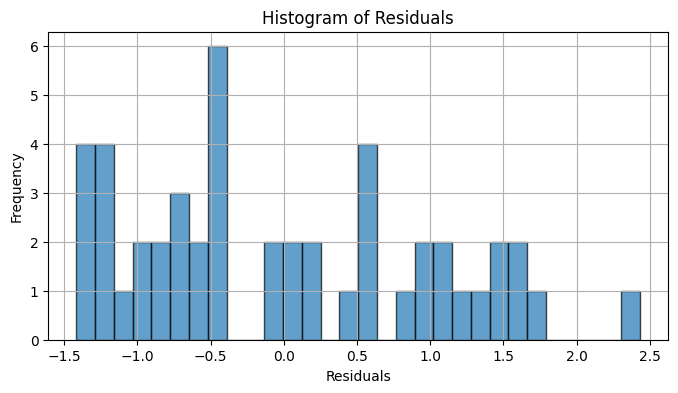

In [5]:
import matplotlib.pyplot as plt

# Assuming results is already defined and contains the residuals
residuals = results.resid

# Plotting the histogram of residuals
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [6]:
# Perform linear regression
X_2 = df[['y_minus_1']]
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(df['y'], X_2)
results_2 = model_2.fit()

# # Print the regression results
# print(results_2.summary())

In [7]:
print(results_2.params)
theta_0 = results_2.params['const']
theta_1 = results_2.params['y_minus_1']
print(f'\ntheta_0: {theta_0:.7}\ntheta_1: {theta_1:.7}')

const        5.360271
y_minus_1    0.465137
dtype: float64

theta_0: 5.360271
theta_1: 0.4651369


In [8]:
print(phi_0 / (1 - (2*alfa_1)))
print(theta_0)
print((phi_1 - alfa_1) / (1 - (2*alfa_1)))
print(theta_1)

10.714985104387742
5.360271259298518
-0.07252777011927879
0.46513692302805476


In [55]:
y_rebuild = phi_0 + (phi_1 * y_minus_1) + (alfa_1 * y_plus_1) + results.resid

y_btf = results.predict(X)

t_1 = phi_0 / (1 - (2*alfa_1))
t_2 = (phi_1 - alfa_1) / (1 - (2*alfa_1))
t_3 = 1 - (2*alfa_1)

# y_btf_reb = t_1 + (t_2 * y_minus_1) + (results.resid / t_3)
y_btf_reb = t_1 + (t_2 * y_minus_1) + results.resid

y_ar_1 = results_2.predict(X_2)

all_models = pd.DataFrame({
                      'y': y,
                    #   'y_rebuild': y_rebuild,
                      'y_btf': y_btf,
                      'y_btf_reb': y_btf_reb,
                      'y_ar_1': y_ar_1,
                      })

display(all_models.head())
display(all_models.tail())

,y,y_btf,y_btf_reb,y_ar_1
0,8.914369,NaN,NaN,NaN
1,10.454530,9.884531,10.638445,9.506674
2,10.781651,9.669711,11.068682,10.223059
3,8.770898,9.735721,8.968193,10.375215
4,8.611436,10.027801,8.662486,9.439940


,y,y_btf,y_btf_reb,y_ar_1
45,10.311661,11.326696,8.910695,10.421942
46,12.327668,10.749820,11.544951,10.156605
47,11.498831,11.419509,9.900209,11.094325
48,11.146235,11.621982,9.405253,10.708802
49,12.436553,NaN,NaN,NaN


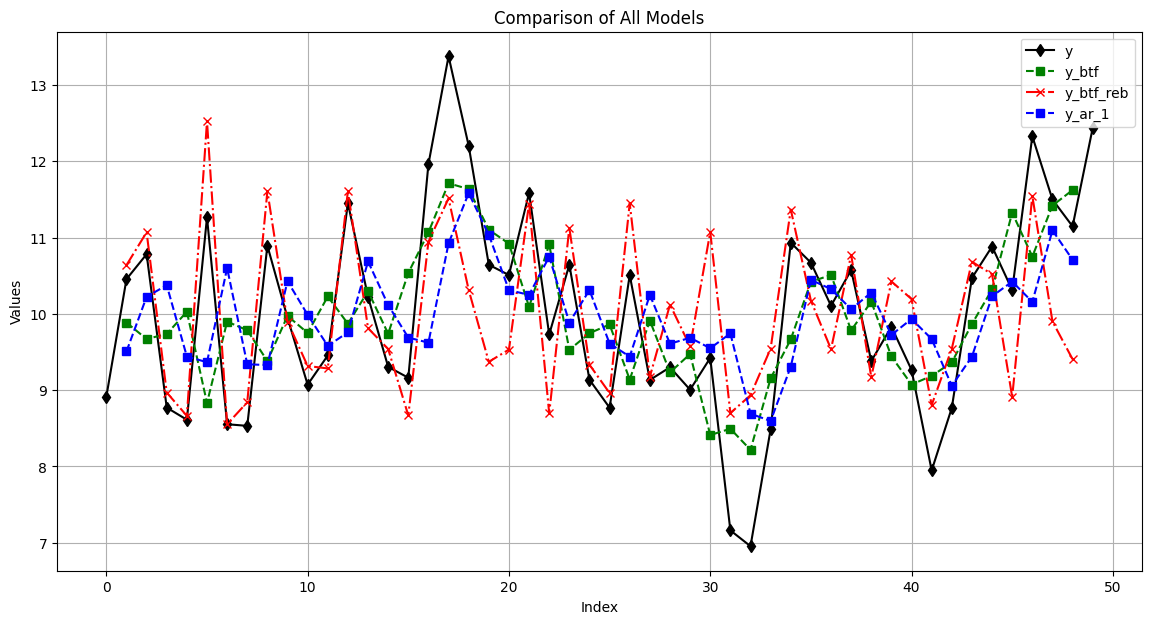

In [56]:
import matplotlib.pyplot as plt

# Define custom styles for each series
styles = {
    'y_rebuild': {'linestyle': '-', 'color': 'blue', 'marker': 'o'},
    'y_btf': {'linestyle': '--', 'color': 'green', 'marker': 's'},
    'y_btf_reb': {'linestyle': '-.', 'color': 'red', 'marker': 'x'},
    'y': {'linestyle': '-', 'color': 'black', 'marker': 'd'},
    'y_ar_1': {'linestyle': '--', 'color': 'blue', 'marker': 's'},
}

# Plot all series in the same graph with custom styles
plt.figure(figsize=(14, 7))

for column in all_models.columns:
    plt.plot(all_models[column], 
             linestyle=styles[column]['linestyle'], 
             color=styles[column]['color'], 
             marker=styles[column]['marker'], 
             label=column)

# Add title and labels
plt.title('Comparison of All Models')
plt.xlabel('Index')
plt.ylabel('Values')

# Add legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()


In [57]:
print(round(results.mse_model, 4))
print(round(results_2.mse_model, 4))

16.3788
17.7353


In [59]:
# Calculate returns from prices
returns1 = all_models['y'].pct_change().dropna()
returns2 = all_models['y_btf_reb'].pct_change().dropna()
returns3 = all_models['y_ar_1'].pct_change().dropna()

# Combine the returns into a DataFrame
returns_data = pd.DataFrame({
    'Returns1': returns1,
    'Returns2': returns2,
    'Returns3': returns3
})

# Calculate the Pearson correlation matrix
correlation_matrix = returns_data.corr(method='pearson')

# Display the correlation matrix
print(correlation_matrix)

          Returns1  Returns2  Returns3
Returns1  1.000000  0.905378 -0.135244
Returns2  0.905378  1.000000 -0.343293
Returns3 -0.135244 -0.343293  1.000000
